## Provided as-is (w/o support)
Kubernetes clusters collect various application and infrastrcuture statistics. While this information is useful, it's very difficult to identify which metrics are useful for monitoring and troubleshooting. The Goal here is to collect this information, and use a statistical model to identify which metrics should be included in reports/dashboard such that:
* Unnecessary overhead and sensory overload can be reduced.
* Time can be saved by prioritising monitoring the correct metrics.

This process needs to assume `zero knowlidge` of the workings of the cluster, workload being run and any other information. This way, `generic` clusters can be monitored without explicitly programming dashboards based on internal knowlidge. This is also a good method to discover/verify  application knowlidge/bottlenecks with statistical data analyis. 

## Step1: Data Loading 
We will load cpu, memory, task_queue information along with stats from strcutured and unstrucutred scans from csv files stored on disk using the `dataframeLoader` helper.
```python
# The dataframeLoader helper function implements the loadApplianceTimeSeriesData method.
# This method loads the csv files, and pivots them to generate distinct "metrics" timeseries. 
# see https://github.com/amitgupta7/docker-jupy-ntbk-s3-reporting/blob/main/dataframeLoader.py
``` 

In [1]:
import dataframeLoader as dfl
import pandas as pd
from importlib import reload 
reload(dfl)

# Provide csv data location and appliance and timerange information.
root = '../../dataDir'
fromDt = '2024-08-15'
toDt = '2024-10-15'

# Provide list of prometheus metrics to load. 
# metricsArr = ['cpu_used', 'download_workers_count', 'memory_used', 'task_queue_length', 'infra_access_latency', 'pod_cpu_usage', 'pod_memory_usage'] 
metricsArr = ['cpu_used'
              ,'task_queue_length'
              , 'memory_used'
              ]

daterange=[fromDt, toDt]
df = dfl.loadApplianceTimeSeriesData(root, metricsArr, daterange)

loading Unstrctured Data from file: SCANPROC-*.csv
loading Strctured Data from file: STRUCTURED-*.csv
processing securiti_appliance_cpu_used-max*.csv
processing securiti_appliance_cpu_used-avg*.csv
processing securiti_appliance_task_queue_length-max*.csv
processing securiti_appliance_task_queue_length-avg*.csv
processing securiti_appliance_memory_used-max*.csv
processing securiti_appliance_memory_used-avg*.csv
loading Unstrctured Data from file: UNSTRUCTURED-*.csv


## Step2: Data Pivoting
We now aggregate the data by `appliance_id` (unique identifier for our cluster) and `ts` timestamp, to get different metrics values as separate columns. Notice there are:
* 21 metrics 
* Tracked every hour

In [2]:
dfp = df.pivot_table(index=['appliance_id','ts'], columns=['metrics'], values='value', aggfunc='sum').reset_index()
dfp.head()

metrics,appliance_id,ts,IdleTimeInHrs,avgFileSizeInMB,cpu_used_avg,cpu_used_max,dataScannedinGB,fileDownloadTimeInHrs,linkerq_avg,linkerq_max,...,memory_used_max,numFilesScanned,numberOfChunksScanned,numberOfColsScanned,scanTime,taskq_avg,taskq_max,tmp_taskq_avg,tmp_taskq_max,uniqPodCount
0,0036f473-ad7f-4439-8d37-f65fdeb50b2d,2024-10-13 14:00:00,NaN,NaN,3.021810,21.46,NaN,NaN,NaN,NaN,...,74.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0036f473-ad7f-4439-8d37-f65fdeb50b2d,2024-10-13 15:00:00,NaN,NaN,1.569917,3.14,NaN,NaN,NaN,NaN,...,66.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0036f473-ad7f-4439-8d37-f65fdeb50b2d,2024-10-13 16:00:00,NaN,NaN,1.748750,2.98,NaN,NaN,NaN,NaN,...,66.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0036f473-ad7f-4439-8d37-f65fdeb50b2d,2024-10-13 17:00:00,NaN,NaN,1.740000,1.93,NaN,NaN,NaN,NaN,...,66.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0036f473-ad7f-4439-8d37-f65fdeb50b2d,2024-10-13 18:00:00,NaN,NaN,1.740000,1.93,NaN,NaN,NaN,NaN,...,66.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3: Data transformation and correlation
We need to acheve two main goals:
1. Isolate data for individual appliance.
2. Remove ghost correlation between unrelated metrics.
    * We will calculate percentage change between adjacent timeseries values.
3. Calculate absolute correlation between metrics for each single appliance.
    * Transpose every `metrics` corelation.
4. Generate correlation for every `appliance_id` and `metric` identifier using steps 1, 2 and 3


In [3]:
# appliance = '01c75278-9c0d-41be-b693-c970b18dbedc'
# for metric in metrics_category_order:
dfc_arr = []
for pod in dfp.appliance_id.unique():
    dfa = dfp[(dfp.appliance_id == pod)]
    dfa = dfa.drop(['appliance_id', 'ts'], axis=1)
    dfa = dfa.pct_change(periods=1, fill_method=None)
    dfca = dfa.corr().abs()
    # print(type(dfca))
    for col in dfca.columns:
        # print(col)
        dfc = dfca[col].to_frame().T
        dfc.insert(0, 'metric', col )
        dfc.insert(0, 'appliance_id', pod )
        dfc_arr.append(dfc)
dfc = pd.concat(dfc_arr, ignore_index=True)
dfc.set_index('appliance_id', inplace=True)
dfc.head()


metrics,metric,IdleTimeInHrs,avgFileSizeInMB,cpu_used_avg,cpu_used_max,dataScannedinGB,fileDownloadTimeInHrs,linkerq_avg,linkerq_max,memory_used_avg,memory_used_max,numFilesScanned,numberOfChunksScanned,numberOfColsScanned,scanTime,taskq_avg,taskq_max,tmp_taskq_avg,tmp_taskq_max,uniqPodCount
appliance_id,,,,,,,,,,,,,,,,,,,,
0036f473-ad7f-4439-8d37-f65fdeb50b2d,IdleTimeInHrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0036f473-ad7f-4439-8d37-f65fdeb50b2d,avgFileSizeInMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0036f473-ad7f-4439-8d37-f65fdeb50b2d,cpu_used_avg,NaN,NaN,1.000000,0.536825,NaN,NaN,NaN,NaN,0.323098,0.622750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0036f473-ad7f-4439-8d37-f65fdeb50b2d,cpu_used_max,NaN,NaN,0.536825,1.000000,NaN,NaN,NaN,NaN,0.907248,0.256122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0036f473-ad7f-4439-8d37-f65fdeb50b2d,dataScannedinGB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 4: Isolate related metrics using correlation
We now iterate over each `metric`, to see if there is any significant statistical correlation to be found across `appliance_id`s. This is done with two steps:

1. Removing outliers:
    * Remove any metrics with `mean correlation value below the cut-off`. The cut-off can be varied for depending on use cases:
        * 0.9 for Exec Dashboards
        * 0.7 for Customer Ops
        * 0.5 for L1 - support
        * 0.3 for L2 - suport 

Please note that we are filtering metrics with `mean` correlation below the `low cut-off`. This ensures that atleast half of the values are correlated to reduce outliers.

2. Plot box chart to visually represent metrics with any correlation (for cutoff as 0.3).  

3. Decide between `max` or `avg` values if both are present. We chose to display `avg` values metrics in this case. 

## Final List of metrics 
The below table shows the list of `metrics` that are useful with respective correlation `cutoff`. The cut-off values can be interpreted as follows:
* below 0.3     negligible correlation
* 0.3 to 0.5    Low positive (negative) correlation
* 0.5 to 0.7    Moderate positive (negative) correlation
* 0.7 to 0.9    High positive (negative) correlation
* 0.9 to 0.1    Very High positive (negative) correlation

| 0.9                   | 0.7                   | 0.5                   | 0.3                   |
| --------------------- | --------------------- | --------------------- | --------------------- |
| linkerq_avg           | linkerq_avg           | linkerq_avg           | linkerq_avg           |
| numberOfChunksScanned | numberOfChunksScanned | numberOfChunksScanned | numberOfChunksScanned |
| numberOfColsScanned   | numberOfColsScanned   | numberOfColsScanned   | numberOfColsScanned   |
| numFilesScanned       | numFilesScanned       | numFilesScanned       | numFilesScanned       |
|                       | scanTime              | scanTime              | scanTime              |
|                       | tmp_taskq_avg         | tmp_taskq_avg         | tmp_taskq_avg         |
|                       | fileDownloadTimeInHrs | fileDownloadTimeInHrs | fileDownloadTimeInHrs |
|                       |                       | avgFileSizeInMB       | avgFileSizeInMB       |
|                       |                       | dataScannedinGB       | dataScannedinGB       |
|                       |                       | memory_used_avg       | memory_used_avg       |
|                       |                       | IdleTimeInHrs         | IdleTimeInHrs         |
|                       |                       | cpu_used_avg          | cpu_used_avg          |
|                       |                       |                       | uniqPodCount          |


0.9 {'linkerq_avg', 'numberOfChunksScanned', 'numFilesScanned', 'numberOfColsScanned'}
0.7 {'linkerq_avg', 'scanTime', 'fileDownloadTimeInHrs', 'numberOfColsScanned', 'tmp_taskq_avg', 'numFilesScanned', 'numberOfChunksScanned'}
0.5 {'linkerq_avg', 'IdleTimeInHrs', 'scanTime', 'taskq_avg', 'fileDownloadTimeInHrs', 'dataScannedinGB', 'numberOfColsScanned', 'tmp_taskq_avg', 'memory_used_avg', 'cpu_used_avg', 'numFilesScanned', 'numberOfChunksScanned', 'avgFileSizeInMB'}
0.3 {'linkerq_avg', 'IdleTimeInHrs', 'scanTime', 'taskq_avg', 'fileDownloadTimeInHrs', 'dataScannedinGB', 'numberOfColsScanned', 'uniqPodCount', 'tmp_taskq_avg', 'memory_used_avg', 'cpu_used_avg', 'numFilesScanned', 'numberOfChunksScanned', 'avgFileSizeInMB'}


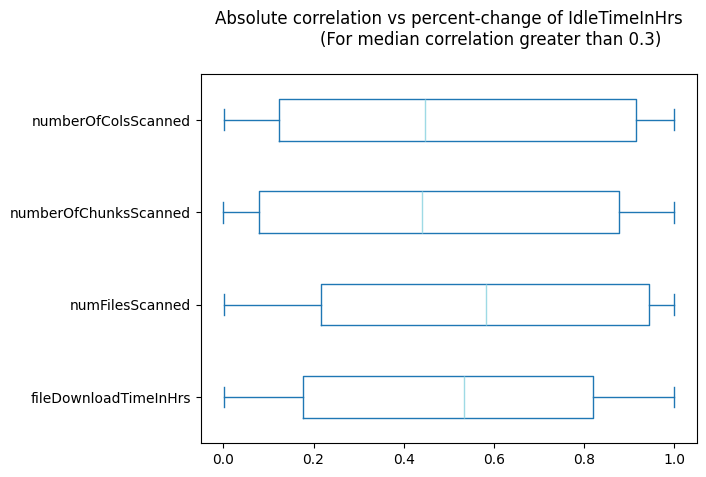

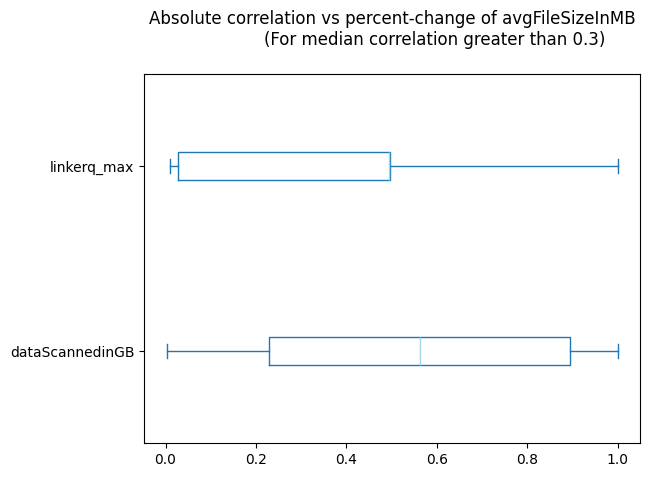

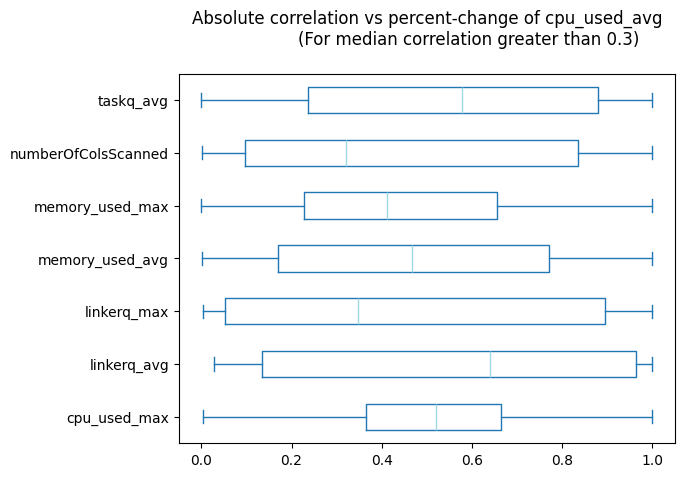

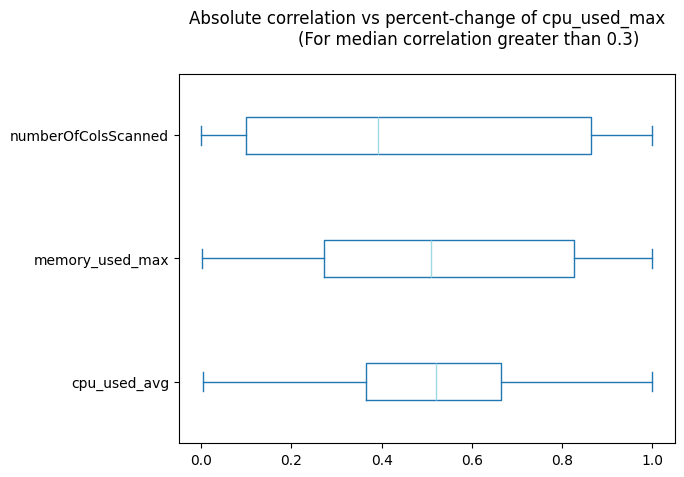

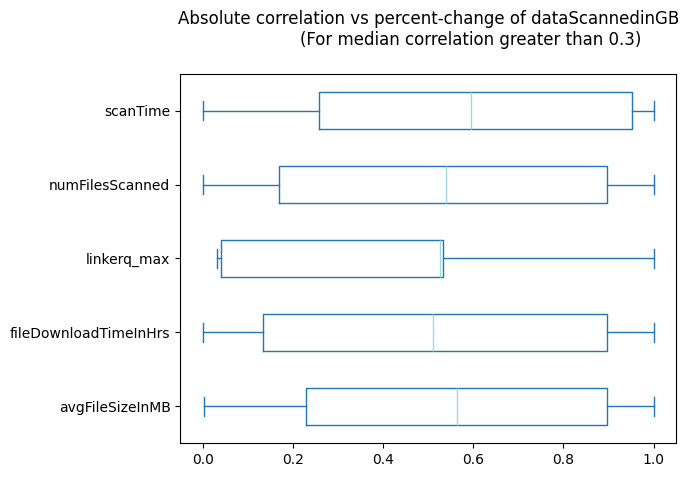

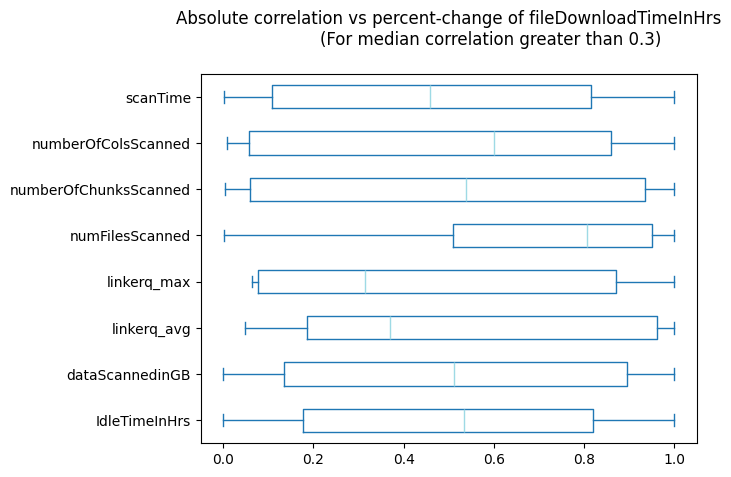

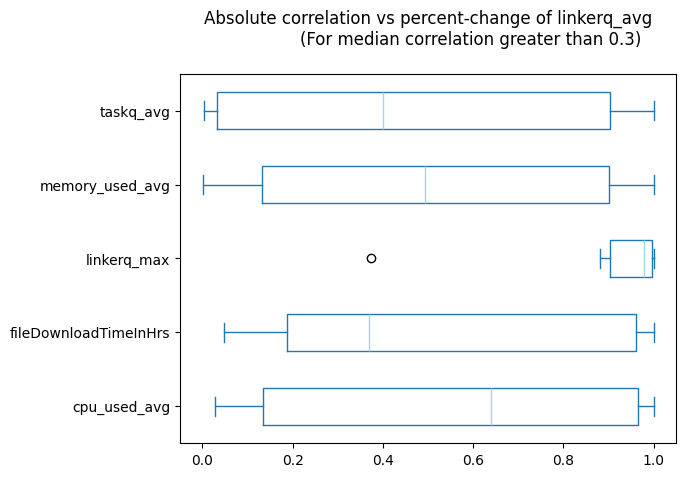

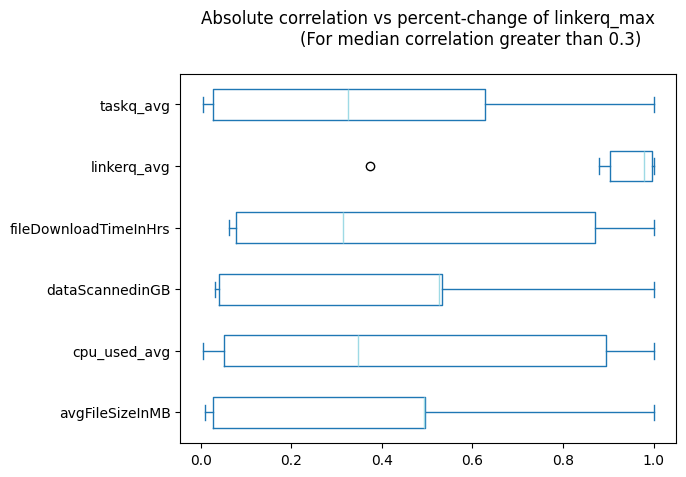

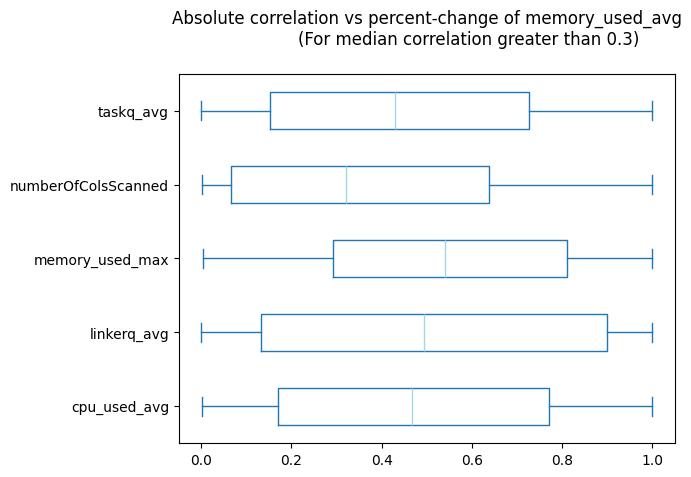

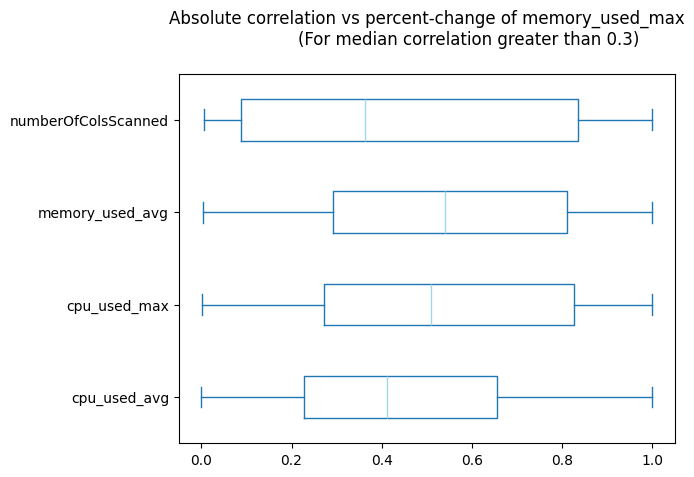

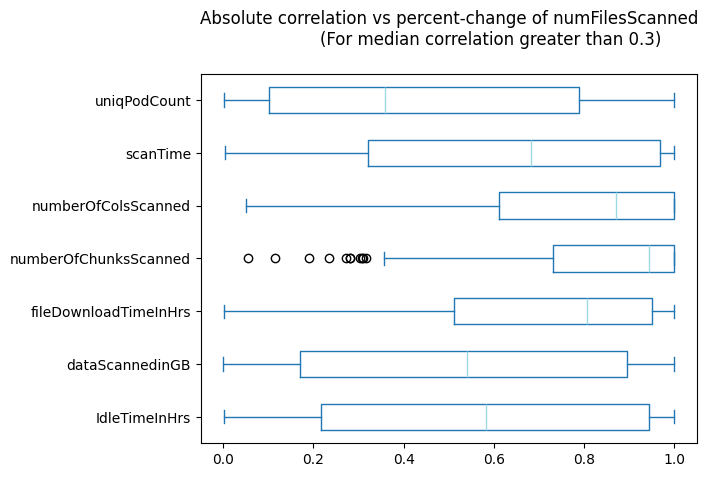

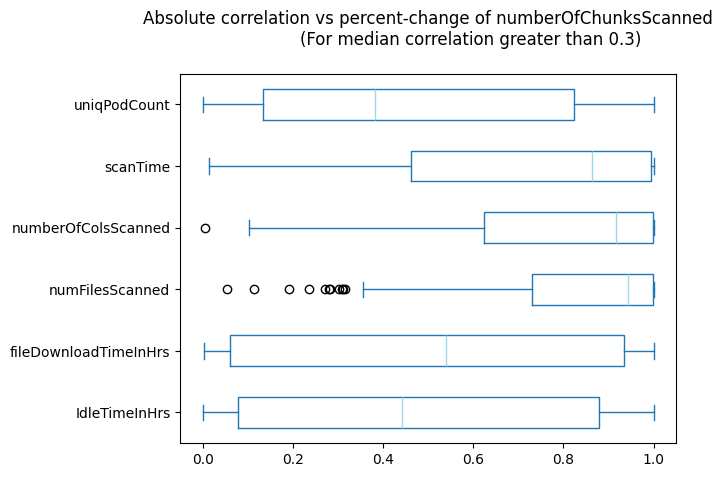

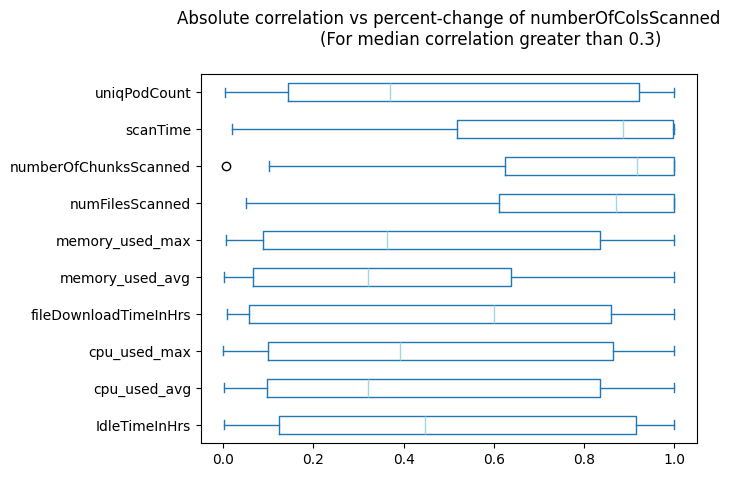

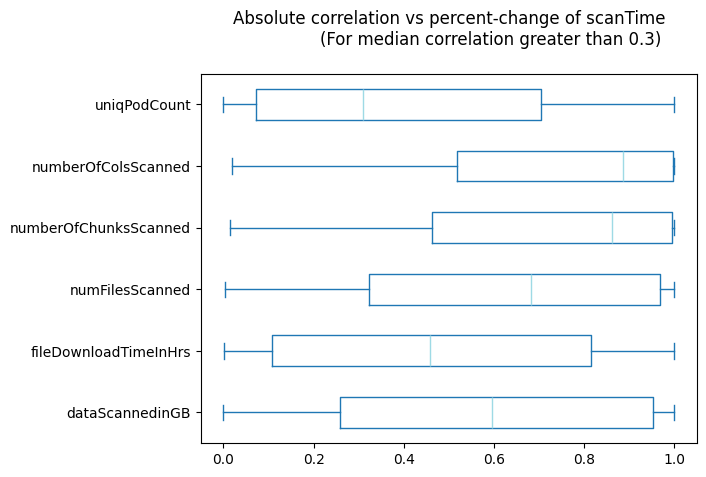

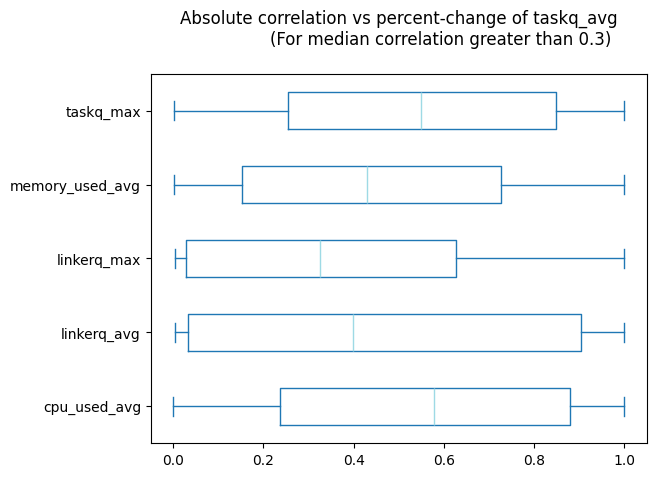

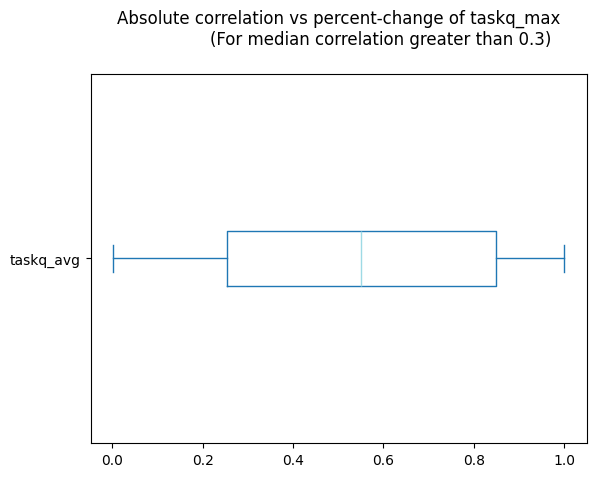

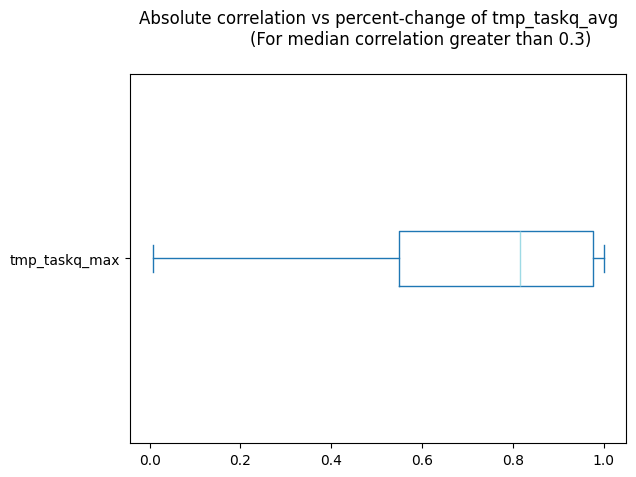

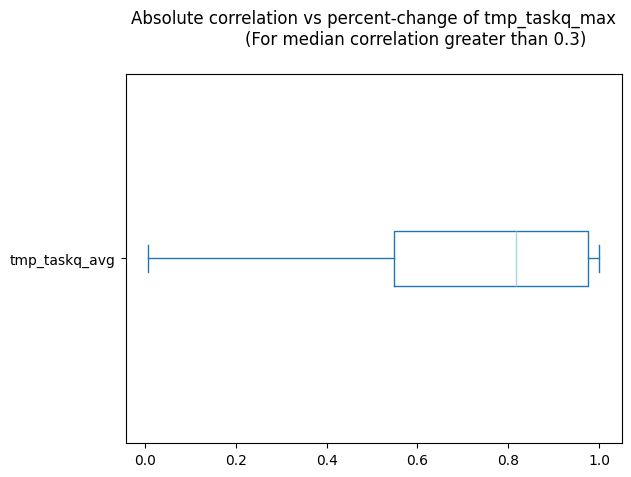

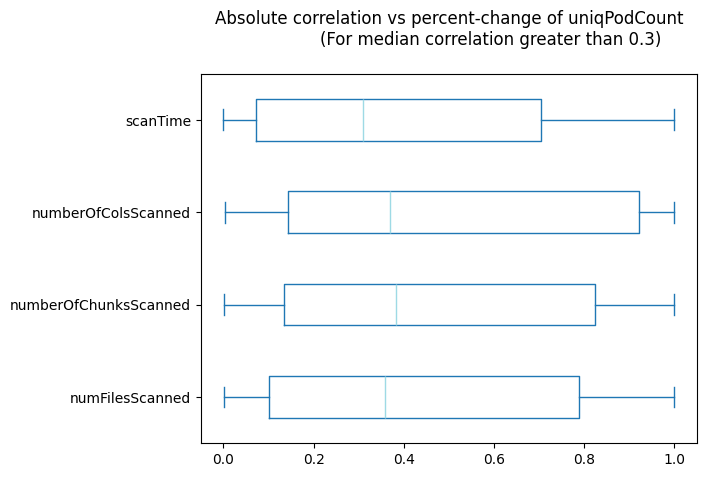

In [4]:
corr_vals = [0.9, 0.7, 0.5, 0.3]
line = set()
for cutoff in corr_vals:
    arr = []
    for metr in dfc.metric.unique():
        dfcm = dfc[(dfc.metric == metr)]
        dfcm = dfcm.drop('metric', axis=1)
        dfcm = dfcm.drop(metr, axis=1)
        dfcm = dfcm.dropna(axis = 0, how = 'all')
        dfcm = dfcm.loc[:, dfcm.median() > cutoff]
        [arr.append(x) for x in dfcm.columns]
        # dfcm = dfcm.dropna(axis = 1,thresh=getMiniumValidValues(dfcm, pct=10, ceiling=10))
        # display(dfcm)
        # break
        if(cutoff == 0.3):
            if len(dfcm.columns) > 0:
                title=f'''Absolute correlation vs percent-change of {metr}
                (For median correlation greater than {cutoff})
                '''
                dfcm.plot(kind='box'
                        ,vert=False
                        ,title=title
                        ,colormap='tab20'
                        )
    for met in set(arr):
        if("max" not in met):
            line.add(met)
    print(cutoff, line)

